In [40]:
import pandas as pd
import scanpy as sc
import numpy as np
import torch
import sys
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'On device: {device}')
dtype = torch.float64
sys.path.insert(0, '/home/ph3641/DeST_OT_LR/')

import util_LR
import DeSTOT_LRDist

On device: cuda


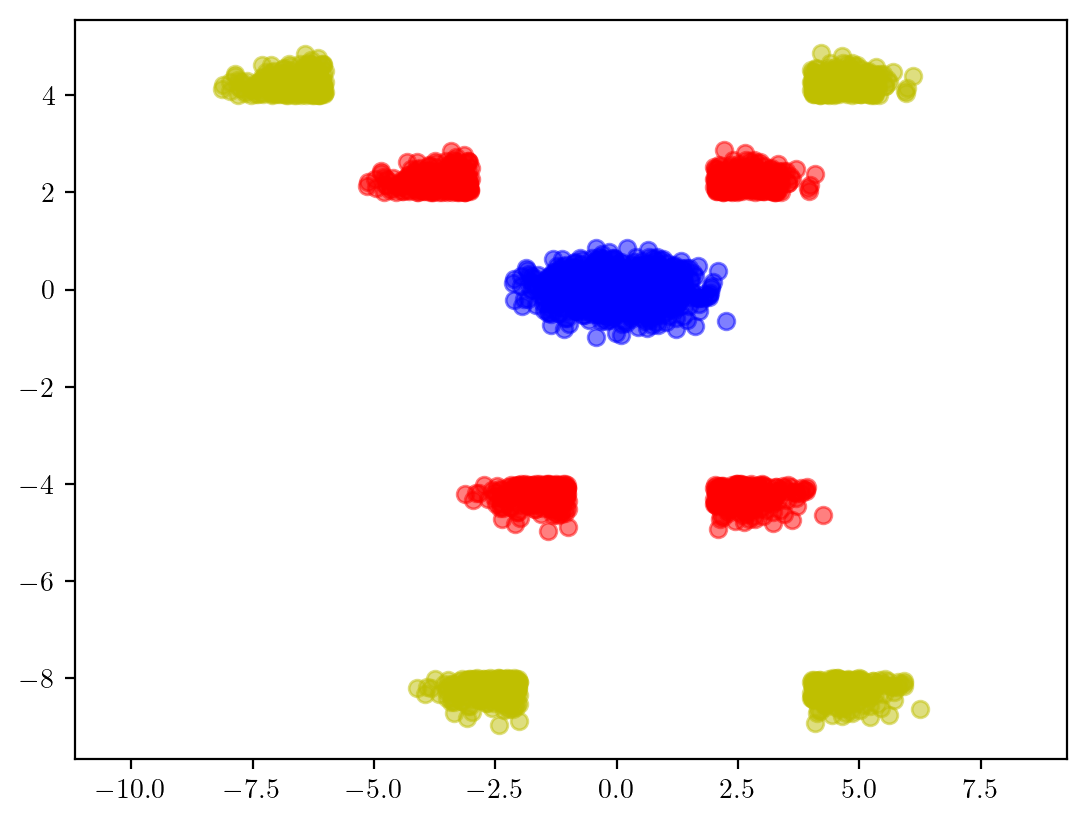

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
'''
sample_size = 100

means = [np.array([0,2]),
         np.array([4,0]),
         np.array([0,-2])]

sig = 0.1

covs = [sig*np.array([[1,0],[0,1]]),
        np.array([[0.1,0],[0,1]]),
        sig*np.array([[1,0],[0,1]])]
 
X1 = np.random.multivariate_normal(means[0], covs[0], size=sample_size)
X2 = np.random.multivariate_normal(means[1], covs[1], size=sample_size)
X3 = np.random.multivariate_normal(means[2], covs[2], size=sample_size)

plt.scatter(X1[:,0], X1[:,1], c='b')
plt.scatter(X2[:,0], X2[:,1], c='r')
plt.scatter(X3[:,0], X3[:,1], c='y')
plt.axis('equal')
plt.show()
'''
#center_t1_A = np.array([3, -5])
center_t1_A = np.array([0, 0])

center_t2_B = np.array([3, 1])
center_t2_C = np.array([-2, 1])
center_t3_D = np.array([4, 5])
center_t3_E = np.array([-3,5])

cov_t1_A = np.array([[6, 0], [0, 1]])
cov_t2_B = np.array([[2, 0], [0, 1]])
cov_t2_C = np.array([[2, 0], [0, 1]])
cov_t3_D = np.array([[2, 0], [0, 1]])
cov_t3_E = np.array([[2, 0], [0, 1]])

num_A = 1000
num_B = 75
num_C = 75
num_D = 100
num_E = 100

var = .1 # var of Gaussians used to make each cluster

t1_A = np.random.multivariate_normal(center_t1_A, var*cov_t1_A, size=num_A)
t2_B = np.random.multivariate_normal(center_t2_B, var*cov_t2_B, size=num_B)
t2_C = np.random.multivariate_normal(center_t2_C, var*cov_t2_C, size=num_C)
t3_D = np.random.multivariate_normal(center_t3_D, var*cov_t3_D, size=num_D)
t3_E = np.random.multivariate_normal(center_t3_E, var*cov_t3_E, size=num_E)

# make expression data at each timepoint
X1 = t1_A

def dy_dt(vars, t):
    tau = 0.0
    x, y = vars
    if y > 0 and x > tau:
        dxdt = 2 #y - x
        dydt = 2
    elif y > 0 and x < -tau:
        dxdt = -3 #y - x
        dydt = 2
    elif y < 0 and x > tau:
        dxdt = 2 #y - x
        dydt = -4
    elif y < 0 and x < tau:
        dxdt = -1 #y - x
        dydt = -4
    '''
    else:
        dxdt = 0 #y - x
        dydt = 5
    '''
    '''
    dxdt = y #y - x
    dydt = 2*x - 3*y #5 * x**2 / (4 + x**2) - y
    '''
    return [dxdt, dydt]

X2 = np.zeros(X1.shape)
X3 = np.zeros(X1.shape)

ts = np.array([0, 1, 2])
for i in range(X1.shape[0]):
    IC = X1[i,:]
    solution = np.array( odeint(dy_dt, [IC[0], IC[1]], ts) )
    X2[i,:] = solution[1,:]
    X3[i,:] = solution[2,:]

#X2 = np.concatenate((t2_B, t2_C))
#X3 = np.concatenate((t3_D, t3_E))

plt.scatter(X1[:,0], X1[:,1], c='b', alpha=0.5)
plt.scatter(X2[:,0], X2[:,1], c='r', alpha=0.5)
plt.scatter(X3[:,0], X3[:,1], c='y', alpha=0.5)
plt.axis('equal')
plt.show()

In [42]:
X1 = torch.from_numpy(X1).type(torch.DoubleTensor).to(device)
X2 = torch.from_numpy(X2).type(torch.DoubleTensor).to(device)
X3 = torch.from_numpy(X3).type(torch.DoubleTensor).to(device)

C12 = torch.cdist(X1, X2).to(device)
C23 = torch.cdist(X2, X3).to(device)
c = torch.max(torch.tensor([torch.max(C12), torch.max(C23)]))
C12, C23 = C12/c, C23/c

A11 = torch.cdist(X1, X1).to(device)
A22 = torch.cdist(X2, X2).to(device)
A33 = torch.cdist(X3, X3).to(device)

Cs = [C12, C23]
As = [A11, A22, A33]

Iteration: 0
Iteration: 25
Initial Wasserstein cost: 0.2790589532307223, Triplet cost: 0.006241345225511654, (partial) GW-cost: -9.175086854583302, Total cost: 0.2790589532307223
Final Wasserstein cost: 0.24180648480144154, Triplet cost: 0.0020029554414246684, (partial) GW-cost: -10.628296208220974, Total cost: 0.24180648480144154


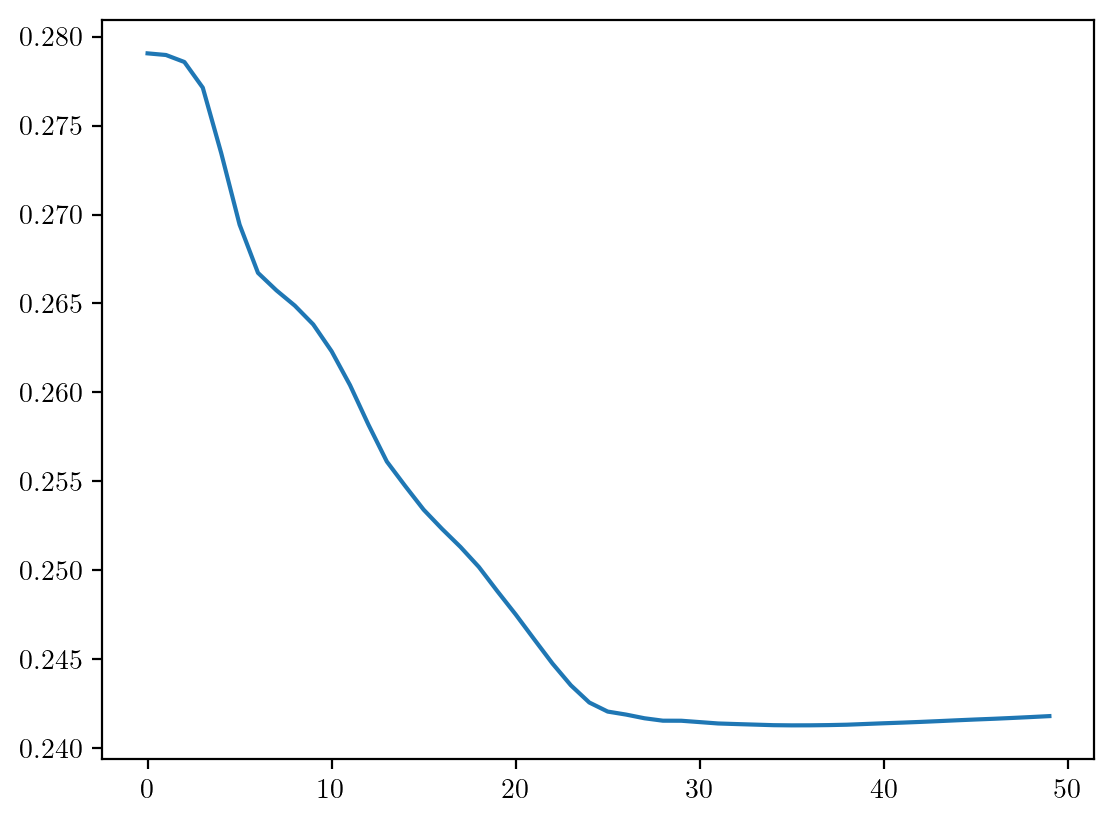

tensor([0.2491, 0.2535, 0.2559, 0.2415], device='cuda:0', dtype=torch.float64)
tensor([0.2614, 0.2470, 0.2130, 0.2765], device='cuda:0', dtype=torch.float64)
Iteration: 0
Iteration: 25
Initial Wasserstein cost: 0.5364481070615332, Triplet cost: 0.014524530178940849, (partial) GW-cost: -63.91616980148031, Total cost: 0.5364481070615332
Final Wasserstein cost: 0.24241058566506477, Triplet cost: 0.0011802514615679017, (partial) GW-cost: -98.3434991515347, Total cost: 0.24241058566506477


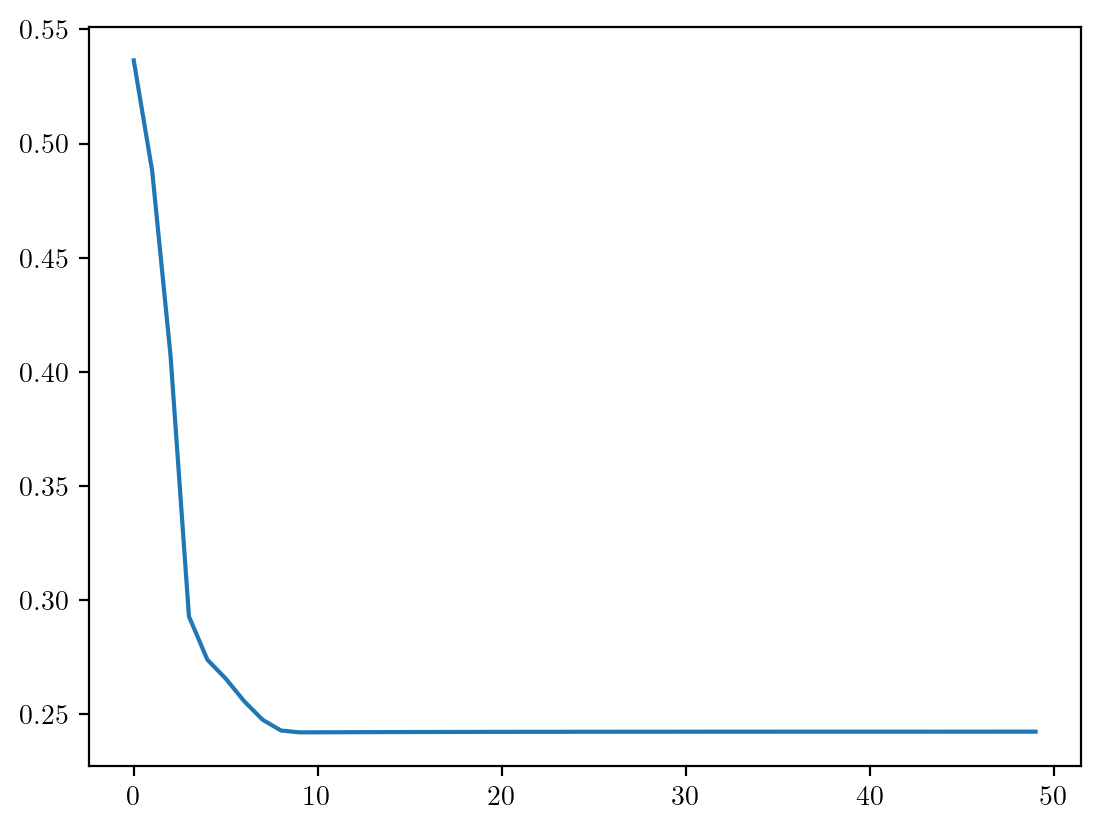

Ranks: r1 4, r2 4, r3 4
Iteration: 0
tensor(30.1942, device='cuda:0', dtype=torch.float64)
tensor(2.8852, device='cuda:0', dtype=torch.float64)
tensor(1037.0664, device='cuda:0', dtype=torch.float64)
tensor(46.5946, device='cuda:0', dtype=torch.float64)
tensor(1145.4362, device='cuda:0', dtype=torch.float64)
tensor(70.9755, device='cuda:0', dtype=torch.float64)
tensor(1167.4957, device='cuda:0', dtype=torch.float64)
tensor(132.7188, device='cuda:0', dtype=torch.float64)
tensor(1173.0455, device='cuda:0', dtype=torch.float64)
tensor(150.2982, device='cuda:0', dtype=torch.float64)
tensor(1175.9336, device='cuda:0', dtype=torch.float64)
tensor(151.5987, device='cuda:0', dtype=torch.float64)
tensor(1180.2206, device='cuda:0', dtype=torch.float64)
tensor(151.8366, device='cuda:0', dtype=torch.float64)
tensor(1185.0476, device='cuda:0', dtype=torch.float64)
tensor(151.9825, device='cuda:0', dtype=torch.float64)
tensor(1186.0174, device='cuda:0', dtype=torch.float64)
tensor(151.9488, device='

"\nplt.scatter(z1[:, 0].cpu().numpy(), z1[:,1].cpu().numpy(),  label='Source warehouses', s=size)\nplt.scatter(z2[:, 0].cpu().numpy(), z2[:,1].cpu().numpy(), label='Intermediate warehouses (1rst pairwise)', s=size)\nplt.scatter(z2_prime[:, 0].cpu().numpy(), z2_prime[:,1].cpu().numpy(), label='Intermediate warehouses (2nd pairwise)', s=size)\nplt.scatter(z2_smoothed[:, 0].cpu().numpy(), z2_smoothed[:,1].cpu().numpy(), label='Intermediate warehouses (multi-marginal)', s=size, c='black')\nplt.scatter(z3[:, 0].cpu().numpy(), z3[:,1].cpu().numpy(), label='Final warehouses', s=size, c='purple')\n"

In [43]:
import importlib

importlib.reload(DeSTOT_LRDist)

gamma=30
tau_out=100
tau_in=10
alpha = 0.0
beta = 0.0

rank=4

# First pair
init_args = (None, None, None)
Q1,R1,T1, errs = DeSTOT_LRDist.DeSTOT_LR_opt((C12, torch.eye(C12.shape[1]).type(torch.DoubleTensor).to(device)),
                                             (A11, torch.eye(A11.shape[1]).type(torch.DoubleTensor).to(device)), 
                                             (A22, torch.eye(A22.shape[1]).type(torch.DoubleTensor).to(device)), \
                                          a=None, b=None, \
                                          r=rank, r2=rank, max_iter= 50, device=device, \
                                         returnFull=False, alpha=alpha, beta=beta, \
                                        min_iter = 50, initialization='Full', tau_out=tau_out, tau_in=tau_in, gamma=gamma, \
                                        dtype=torch.float64, updateR = True, updateQ = True, updateT = True, init_args=init_args)

gQ = Q1.T @ torch.ones(Q1.shape[0]).type(torch.DoubleTensor).to(device)
gR = R1.T @ torch.ones(R1.shape[0]).type(torch.DoubleTensor).to(device)

print(gQ)
print(gR)

z1 = torch.diag(1/ gQ) @ Q1.T @ X1
z2 = torch.diag(1/ gR) @ R1.T @ X2

# Second pair
init_args = (None, None, None)
Q2,R2,T2, errs = DeSTOT_LRDist.DeSTOT_LR_opt((C23, torch.eye(C23.shape[1]).type(torch.DoubleTensor).to(device)),
                                             (A22, torch.eye(A22.shape[1]).type(torch.DoubleTensor).to(device)), 
                                             (A33, torch.eye(A33.shape[1]).type(torch.DoubleTensor).to(device)), \
                                          a=None, b=None, \
                                          r=rank, r2=rank, max_iter=50, device=device, \
                                         returnFull=False, alpha=alpha, beta=beta, \
                                        min_iter = 50, initialization='Full', tau_out=tau_out, tau_in=tau_in, gamma=gamma, \
                                        dtype=torch.float64, updateR = True, updateQ = True, updateT = True, init_args=init_args)

gQ = Q2.T @ torch.ones(Q2.shape[0]).type(torch.DoubleTensor).to(device)
gR = R2.T @ torch.ones(R2.shape[0]).type(torch.DoubleTensor).to(device)

z2_prime = torch.diag(1/ gQ) @ Q2.T @ X2
z3 = torch.diag(1/ gR) @ R2.T @ X3


# Initialize as arguments
init_args = (Q1, R2)

# Learn smoothed co-clustering Q_t
Q_t, T_tm1t, T_ttp1 = DeSTOT_LRDist.DeSTOT_LR_opt_multimarginal((C12, torch.eye(C12.shape[1]).type(torch.DoubleTensor).to(device)), \
                                                               (A11, torch.eye(A11.shape[1]).type(torch.DoubleTensor).to(device)), 
                                                                 (A22, torch.eye(A22.shape[1]).type(torch.DoubleTensor).to(device)), \
                                                (C23, torch.eye(C23.shape[1]).type(torch.DoubleTensor).to(device)), \
                                             (A22, torch.eye(A22.shape[1]).type(torch.DoubleTensor).to(device)), \
                                             (A33, torch.eye(A33.shape[1]).type(torch.DoubleTensor).to(device)), r=rank, max_iter=120, device=device, \
                                             returnFull=False, alpha=alpha, beta=beta, \
                                            min_iter = 100, initialization='Full', tau_out=tau_out, tau_in=tau_in, gamma=gamma, \
                                            dtype=torch.float64, init_args=init_args)
gQ = Q_t.T @ torch.ones(Q_t.shape[0]).type(torch.DoubleTensor).to(device)
z2_smoothed = torch.diag(1/ gQ) @ Q_t.T @ X2


'''
plt.scatter(z1[:, 0].cpu().numpy(), z1[:,1].cpu().numpy(),  label='Source warehouses', s=size)
plt.scatter(z2[:, 0].cpu().numpy(), z2[:,1].cpu().numpy(), label='Intermediate warehouses (1rst pairwise)', s=size)
plt.scatter(z2_prime[:, 0].cpu().numpy(), z2_prime[:,1].cpu().numpy(), label='Intermediate warehouses (2nd pairwise)', s=size)
plt.scatter(z2_smoothed[:, 0].cpu().numpy(), z2_smoothed[:,1].cpu().numpy(), label='Intermediate warehouses (multi-marginal)', s=size, c='black')
plt.scatter(z3[:, 0].cpu().numpy(), z3[:,1].cpu().numpy(), label='Final warehouses', s=size, c='purple')
'''

'''
plt.scatter(z1[:, 0].cpu().numpy(), z1[:,1].cpu().numpy(),  label='Source warehouses', s=size)
plt.scatter(z2[:, 0].cpu().numpy(), z2[:,1].cpu().numpy(), label='Intermediate warehouses (1rst pairwise)', s=size)
plt.scatter(z2_prime[:, 0].cpu().numpy(), z2_prime[:,1].cpu().numpy(), label='Intermediate warehouses (2nd pairwise)', s=size)
plt.scatter(z2_smoothed[:, 0].cpu().numpy(), z2_smoothed[:,1].cpu().numpy(), label='Intermediate warehouses (multi-marginal)', s=size, c='black')
plt.scatter(z3[:, 0].cpu().numpy(), z3[:,1].cpu().numpy(), label='Final warehouses', s=size, c='purple')
'''

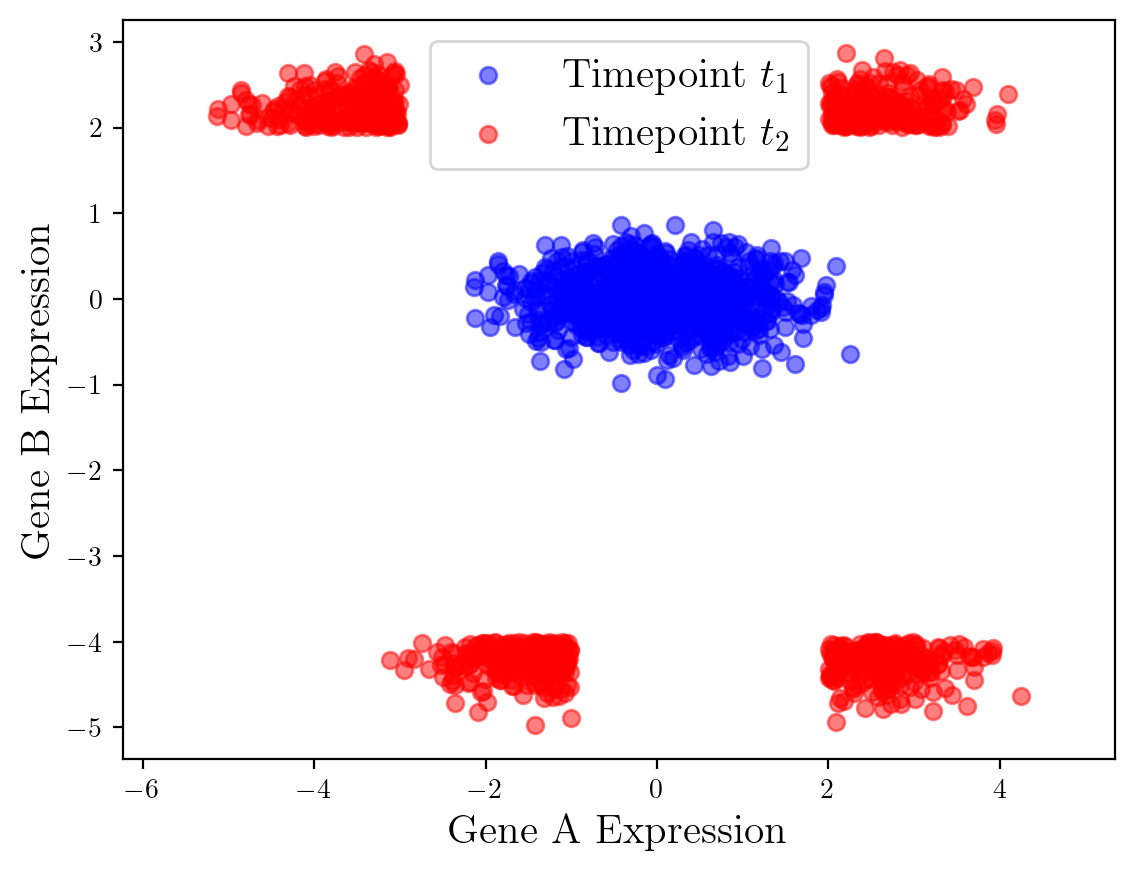

In [44]:
### Plotting ###
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Times New Roman"],
    "figure.dpi": 200  # Set the DPI
})


plt.scatter(X1[:,0].cpu().numpy(), X1[:,1].cpu().numpy(), c='b', label=r'Timepoint $t_1$', alpha=0.5)
plt.scatter(X2[:,0].cpu().numpy(), X2[:,1].cpu().numpy(), c='r', label=r'Timepoint $t_2$', alpha=0.5)
#plt.scatter(X3[:,0].cpu().numpy(), X3[:,1].cpu().numpy(), c='y', label=r'Timepoint $t_3$', alpha=0.5)

size = 15

plt.xlabel(r'Gene A Expression', size=size)
plt.ylabel(r'Gene B Expression', size=size)
plt.legend(fontsize=size)
plt.axis('equal')

plt.savefig('synthetic1.svg')

plt.show()

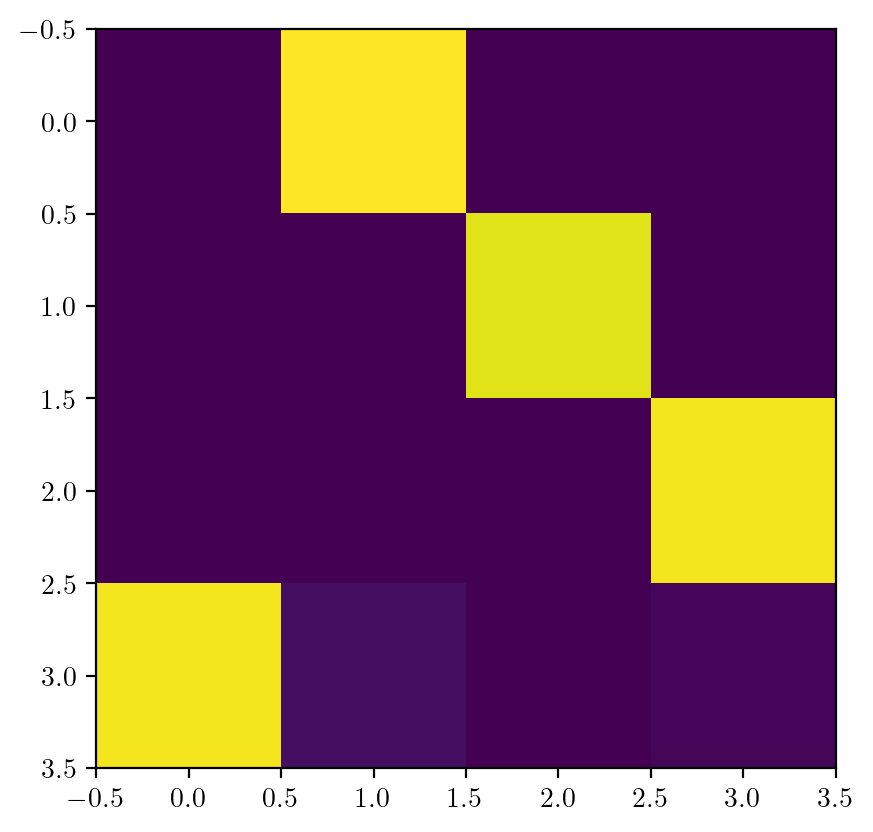

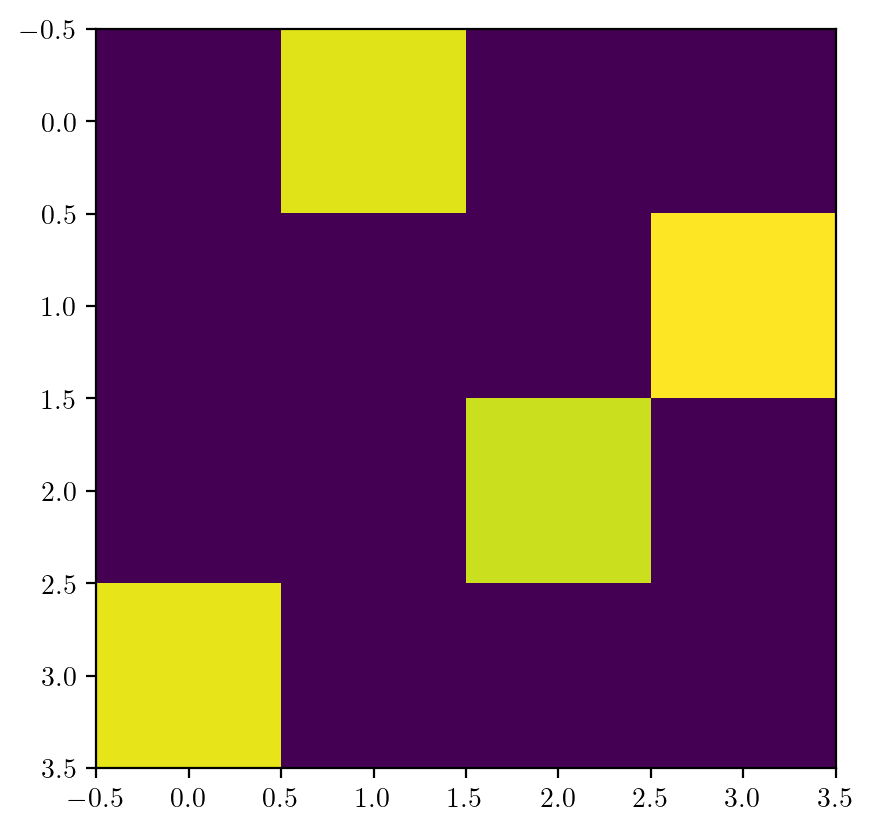

tensor([0, 2, 2, 2, 2, 2, 0, 2, 3, 3, 1, 3, 2, 2, 2, 0, 2, 2, 2, 1, 3, 1, 3, 2,
        3, 0, 0, 2, 0, 1, 3, 3, 0, 0, 3, 0, 2, 1, 0, 3, 2, 3, 0, 0, 0, 2, 0, 1,
        0, 3, 2, 0, 1, 0, 3, 1, 2, 3, 0, 2, 1, 3, 3, 3, 0, 0, 1, 0, 1, 0, 3, 3,
        2, 3, 2, 3, 1, 0, 0, 0, 3, 0, 1, 0, 3, 2, 0, 1, 2, 3, 2, 1, 1, 3, 2, 1,
        1, 1, 1, 0, 2, 1, 3, 1, 1, 3, 2, 0, 1, 1, 1, 1, 1, 0, 3, 3, 3, 2, 2, 0,
        3, 1, 1, 1, 3, 1, 0, 0, 2, 2, 3, 1, 3, 2, 3, 2, 1, 3, 1, 0, 1, 3, 0, 0,
        0, 0, 3, 3, 2, 2, 1, 2, 2, 3, 2, 3, 0, 2, 0, 1, 1, 1, 3, 2, 0, 0, 3, 3,
        3, 2, 3, 2, 2, 3, 1, 3, 0, 3, 0, 1, 2, 2, 2, 3, 0, 2, 2, 0, 2, 1, 2, 1,
        0, 0, 3, 0, 3, 2, 2, 3, 3, 3, 2, 1, 0, 1, 2, 2, 2, 1, 3, 1, 1, 0, 1, 3,
        3, 1, 2, 0, 2, 1, 1, 1, 3, 3, 1, 1, 3, 3, 1, 3, 2, 1, 1, 0, 1, 3, 0, 0,
        0, 3, 3, 0, 3, 0, 0, 2, 2, 0, 0, 2, 1, 1, 2, 1, 3, 1, 3, 0, 0, 2, 0, 0,
        3, 3, 3, 2, 2, 0, 3, 1, 1, 2, 3, 2, 1, 1, 3, 1, 1, 2, 2, 3, 3, 3, 0, 0,
        2, 2, 1, 3, 0, 0, 0, 2, 1, 0, 0,

In [6]:
import clustering

#C0, C1 = clustering.ancestral_clustering(Q1.cpu().numpy(),Q_t.cpu().numpy(),T_tm1t.cpu().numpy(), full_P = True)
#C1, C2 = clustering.ancestral_clustering(Q_t.cpu().numpy(),R2.cpu().numpy(),T_ttp1.cpu().numpy(), full_P = True)

plt.imshow(T_tm1t.cpu().numpy())
plt.show()
plt.imshow(T_ttp1.cpu().numpy())
plt.show()

C0 = Q1
C1 = (T_tm1t @ torch.diag(1/ (Q_t.T @ torch.ones(Q_t.shape[0]).type(torch.DoubleTensor).to(device)) ) @ Q_t.T).T
C2 = (T_ttp1 @ torch.diag(1/ (R2.T @ torch.ones(R2.shape[0]).type(torch.DoubleTensor).to(device)) ) @ R2.T).T

print(torch.argmax(C0, axis=1))
print(torch.argmax(C1, axis=1))
print(torch.argmax(C2, axis=1))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


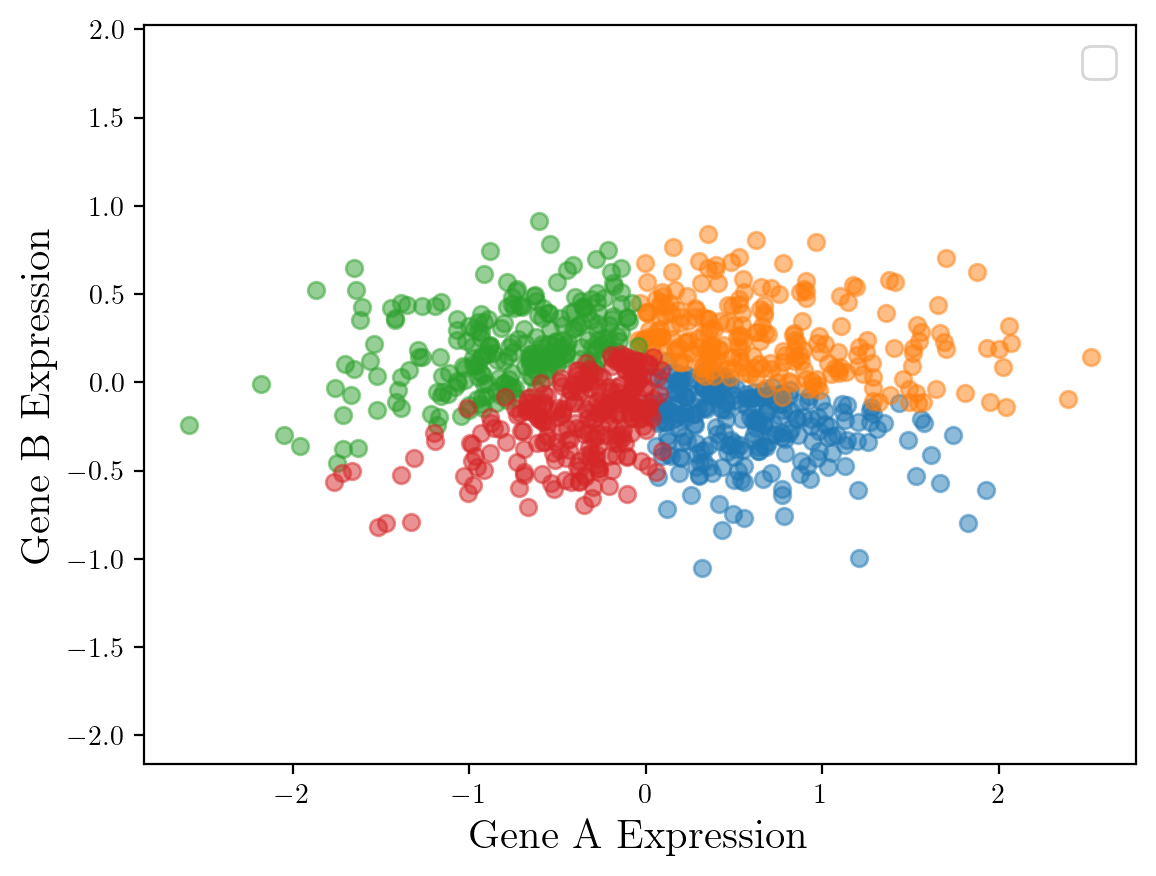

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


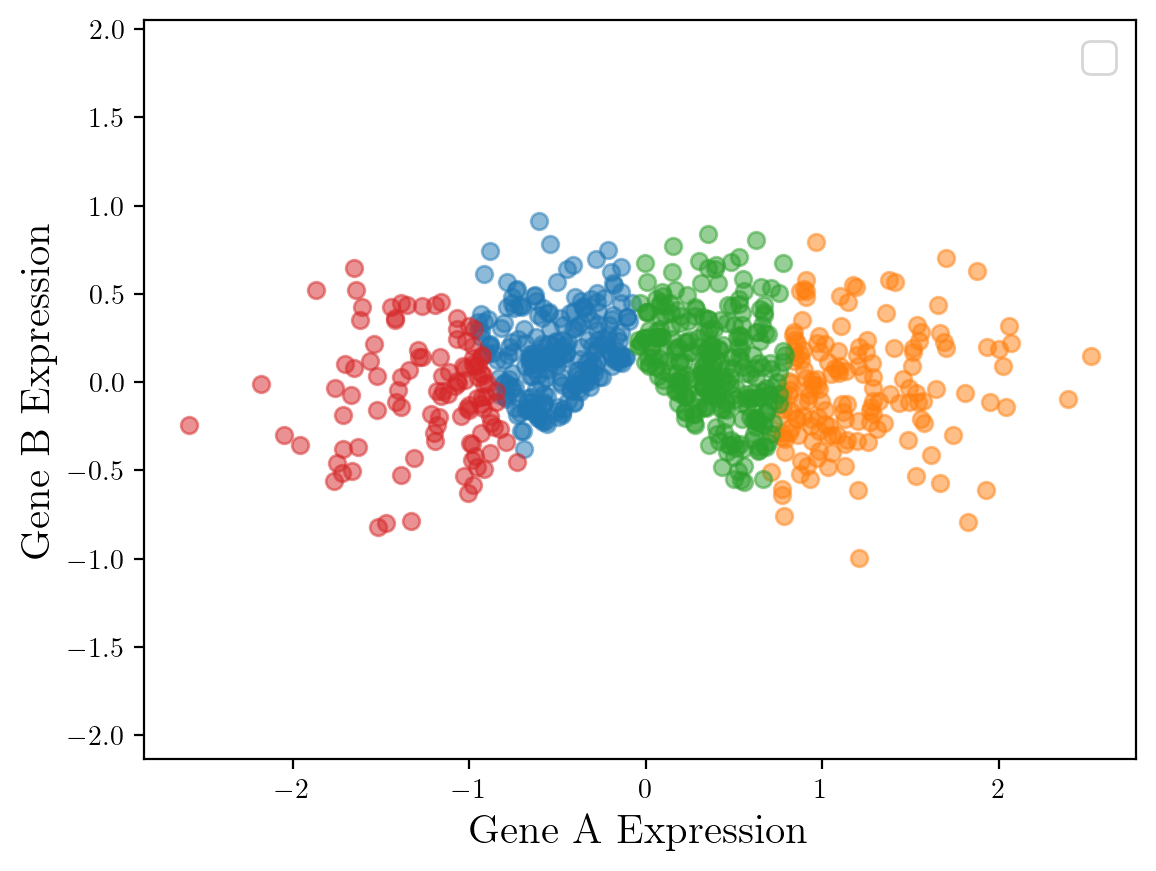

In [7]:
from sklearn.cluster import KMeans
import numpy as np

### Plotting ###
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Times New Roman"],
    "figure.dpi": 200  # Set the DPI
})

size = 15

for c in range(rank):
    XC = X1[torch.argmax(C0, axis=1) == c].cpu().numpy()
    plt.scatter(XC[:,0], XC[:, 1], alpha=0.5)

plt.xlabel(r'Gene A Expression', size=size)
plt.ylabel(r'Gene B Expression', size=size)
plt.legend(fontsize=size)
plt.axis('equal')
plt.show()

kmeans = KMeans(n_clusters=5, random_state=0, n_init="auto").fit(X1.cpu().numpy())

for c in range(rank):
    XC = X1[kmeans.labels_ == c].cpu().numpy()
    plt.scatter(XC[:,0], XC[:, 1], alpha=0.5)

plt.xlabel(r'Gene A Expression', size=size)
plt.ylabel(r'Gene B Expression', size=size)
plt.legend(fontsize=size)
plt.axis('equal')
plt.show()

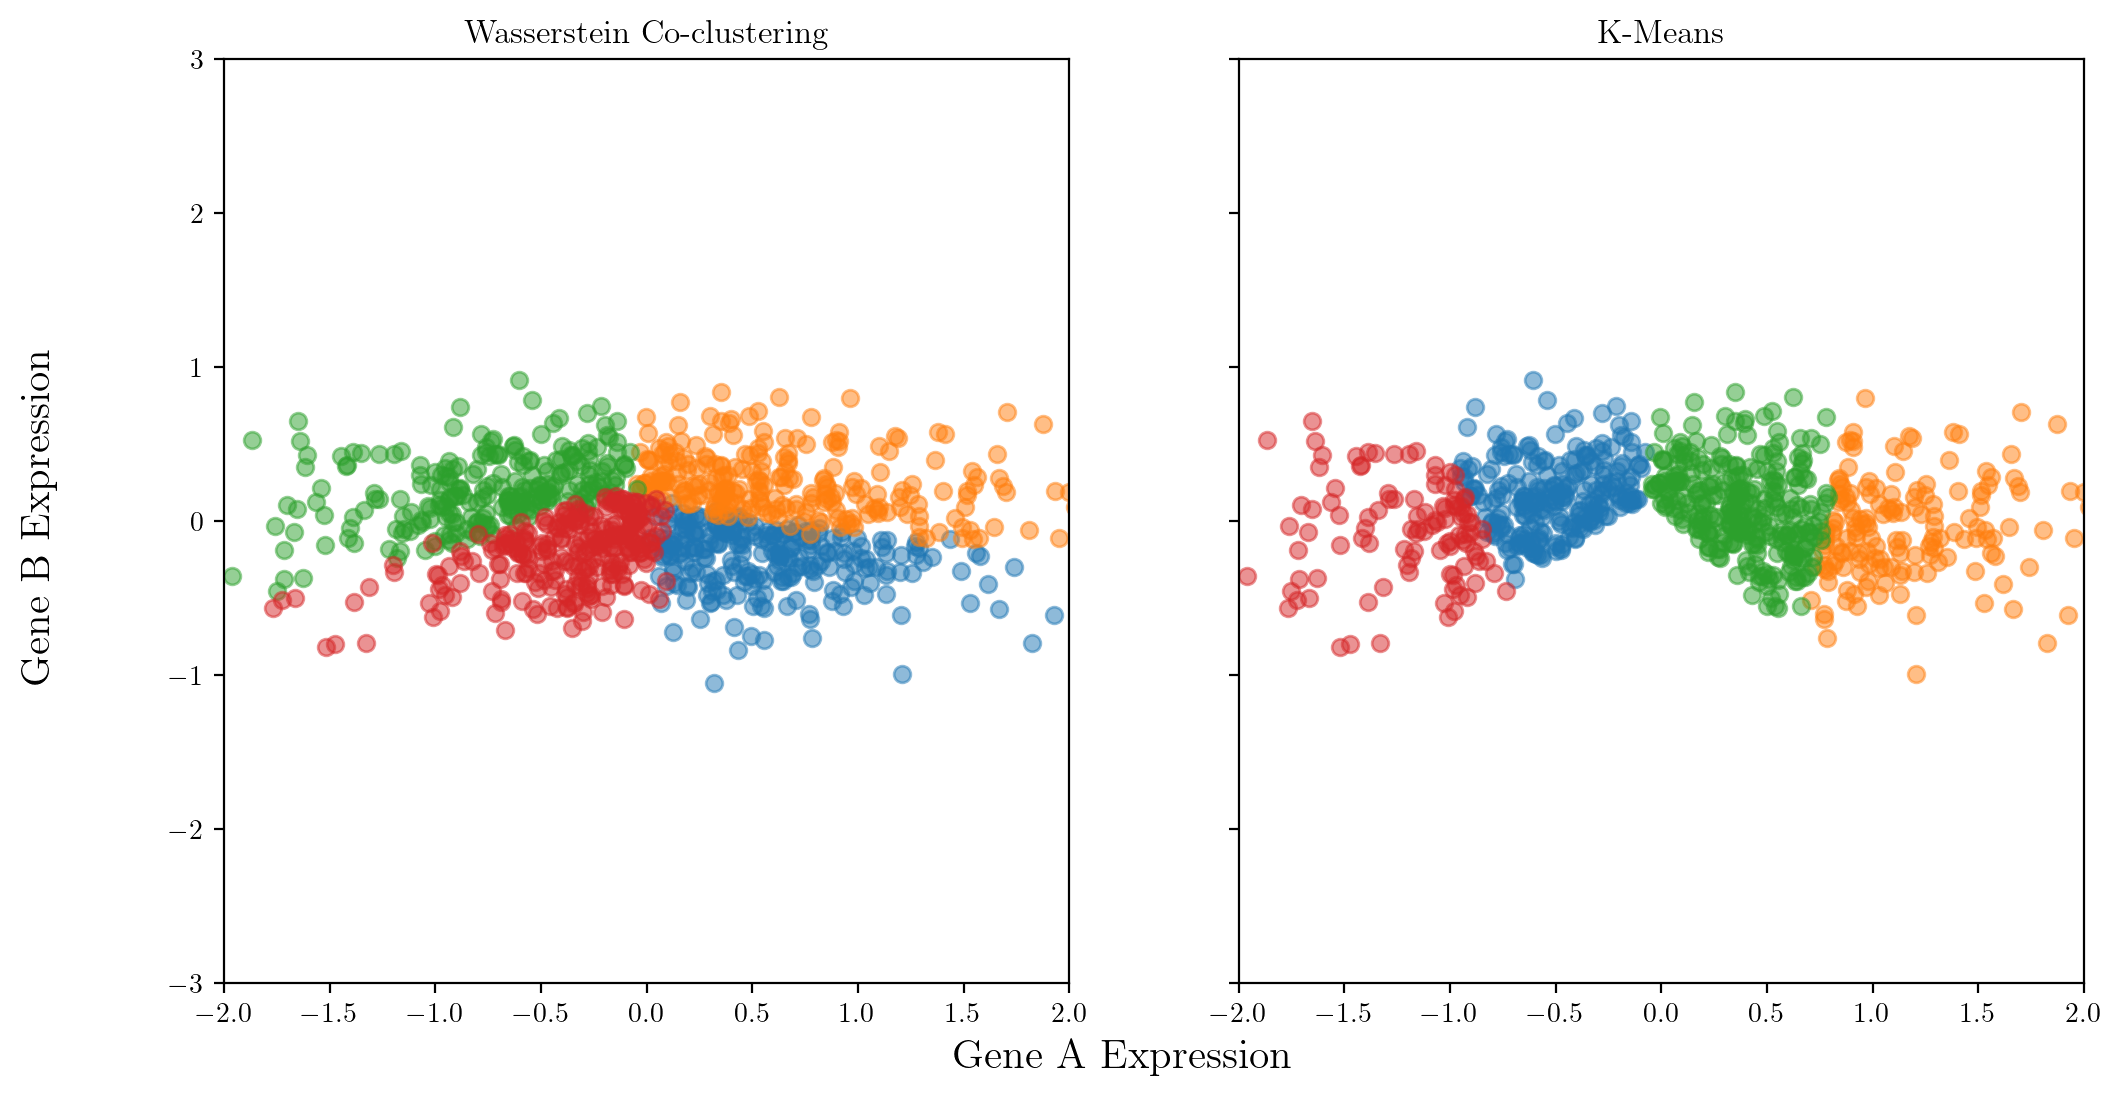

In [8]:
# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)

# First subplot
for c in range(rank):
    XC = X1[torch.argmax(C0, axis=1) == c].cpu().numpy()
    axs[0].scatter(XC[:, 0], XC[:, 1], alpha=0.5)

axs[0].set_title('Wasserstein Co-clustering')
#axs[0].axis('equal')
#axs[0].legend(fontsize=size)

# Second subplot
kmeans = KMeans(n_clusters=5, random_state=0, n_init="auto").fit(X1.cpu().numpy())

for c in range(rank):
    XC = X1[kmeans.labels_ == c].cpu().numpy()
    axs[1].scatter(XC[:, 0], XC[:, 1], alpha=0.5)

axs[1].set_title('K-Means')
#axs[1].axis('equal')
#axs[1].legend(fontsize=size)

# Shared labels
fig.text(0.5, 0.04, r'Gene A Expression', ha='center', size=size)
fig.text(0.04, 0.5, r'Gene B Expression', va='center', rotation='vertical', size=size)


# Set the same x and y limits
axs[0].set_xlim(-2, 2)
axs[0].set_ylim(-3, 3)
axs[1].set_xlim(-2, 2)
axs[1].set_ylim(-3, 3)

plt.savefig('synthetic2.svg')
plt.show()

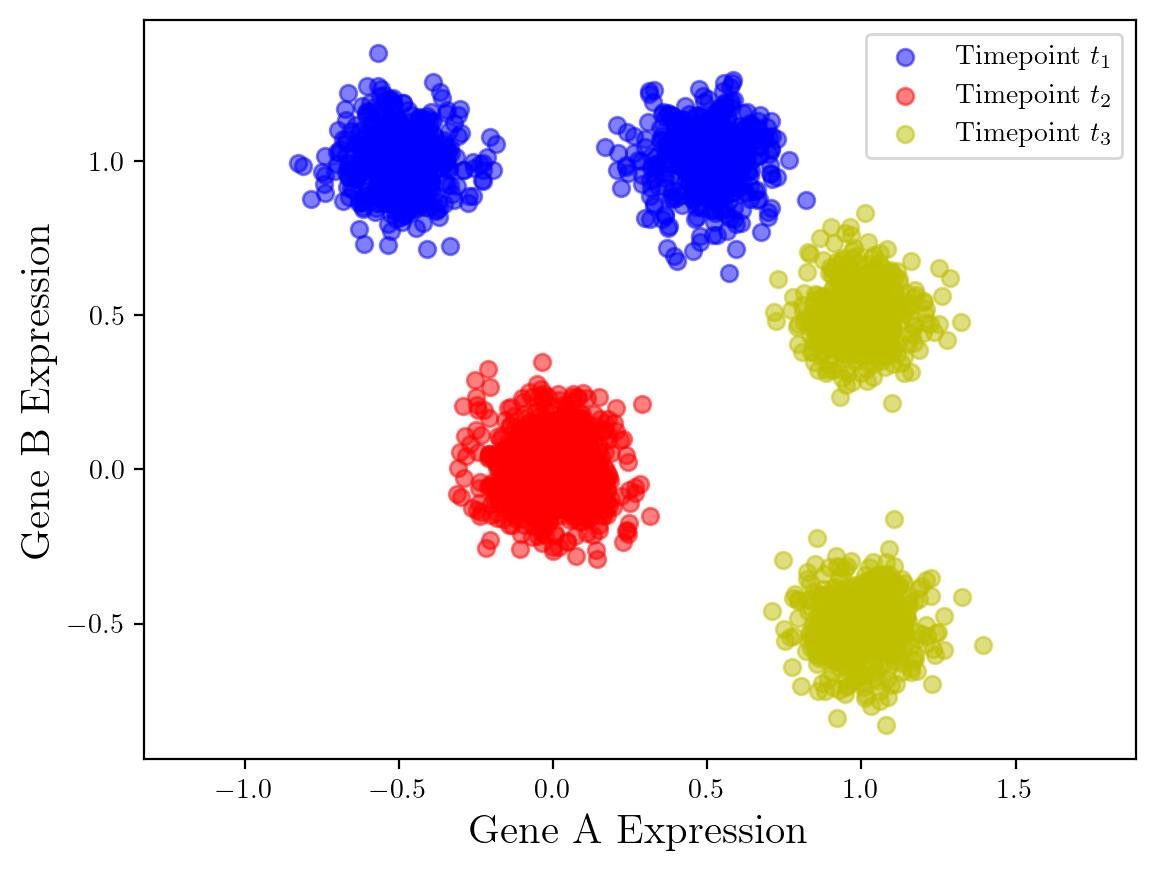

In [38]:
center_t1 = np.array([0, 1])
center_t2 = np.array([0, 0])
center_t3 = np.array([1,0])

cov = np.array([[1, 0], [0, 1]])
var = .01 # var of Gaussians used to make each cluster

num_B = 1000

num_A = int(num_B/2)
num_C = int(num_B/2)

eps=0.5

X1_1 = np.random.multivariate_normal( (center_t1 - np.array([eps, 0])) , var*cov, size=num_A)
X1_2 = np.random.multivariate_normal( (center_t1 + np.array([eps, 0])) , var*cov, size=num_A)
X1 = np.vstack((X1_1, X1_2))
#X1 = np.random.multivariate_normal(center_t1, var*cov, size=num_A)
X2 = np.random.multivariate_normal(center_t2, var*cov, size=num_B)

X3_1 = np.random.multivariate_normal( (center_t3 - np.array([ 0, eps])) , var*cov, size=num_C)
X3_2 = np.random.multivariate_normal( (center_t3 + np.array([0, eps])) , var*cov, size=num_C)
X3 = np.vstack((X3_1, X3_2))

#X3 = np.random.multivariate_normal(center_t3, var*cov, size=num_C)

plt.scatter(X1[:,0], X1[:,1], c='b', alpha=0.5, label=r'Timepoint $t_1$')
plt.scatter(X2[:,0], X2[:,1], c='r', alpha=0.5, label=r'Timepoint $t_2$')
plt.scatter(X3[:,0], X3[:,1], c='y', alpha=0.5, label=r'Timepoint $t_3$')
plt.axis('equal')
plt.xlabel(r'Gene A Expression', size=size)
plt.ylabel(r'Gene B Expression', size=size)
plt.legend()
plt.savefig('synthetic_2.svg')
plt.show()

In [24]:
X1 = torch.from_numpy(X1).type(torch.DoubleTensor).to(device)
X2 = torch.from_numpy(X2).type(torch.DoubleTensor).to(device)
X3 = torch.from_numpy(X3).type(torch.DoubleTensor).to(device)

C12 = torch.cdist(X1, X2).to(device)
C23 = torch.cdist(X2, X3).to(device)
c = torch.max(torch.tensor([torch.max(C12), torch.max(C23)]))
C12, C23 = C12/c, C23/c

A11 = torch.cdist(X1, X1).to(device)
A22 = torch.cdist(X2, X2).to(device)
A33 = torch.cdist(X3, X3).to(device)

Cs = [C12, C23]
As = [A11, A22, A33]

Iteration: 0
Initial Wasserstein cost: 0.4667242313419201, Triplet cost: 0.030016847235488264, (partial) GW-cost: 0.21448280294255878, Total cost: 0.4667242313419201
Final Wasserstein cost: 0.4341298662461116, Triplet cost: 0.04211898963688859, (partial) GW-cost: 0.18479736709286698, Total cost: 0.4341298662461116


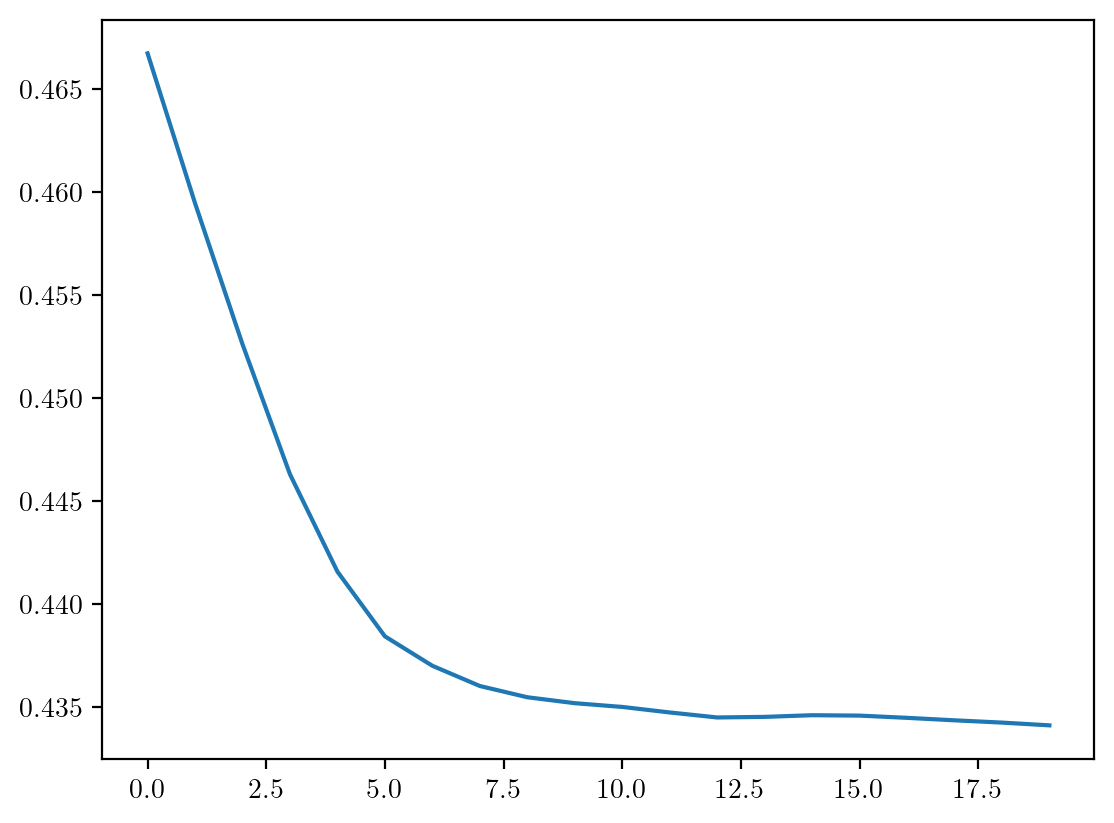

tensor([0.4539, 0.4639], device='cuda:0', dtype=torch.float64)
tensor([0.4982, 0.5018], device='cuda:0', dtype=torch.float64)
Iteration: 0
Initial Wasserstein cost: 0.4868568244898056, Triplet cost: 0.0408808276734399, (partial) GW-cost: -0.09574369170731556, Total cost: 0.4868568244898056
Final Wasserstein cost: 0.46445775949383994, Triplet cost: 0.011196824207578192, (partial) GW-cost: -0.2337061552966948, Total cost: 0.46445775949383994


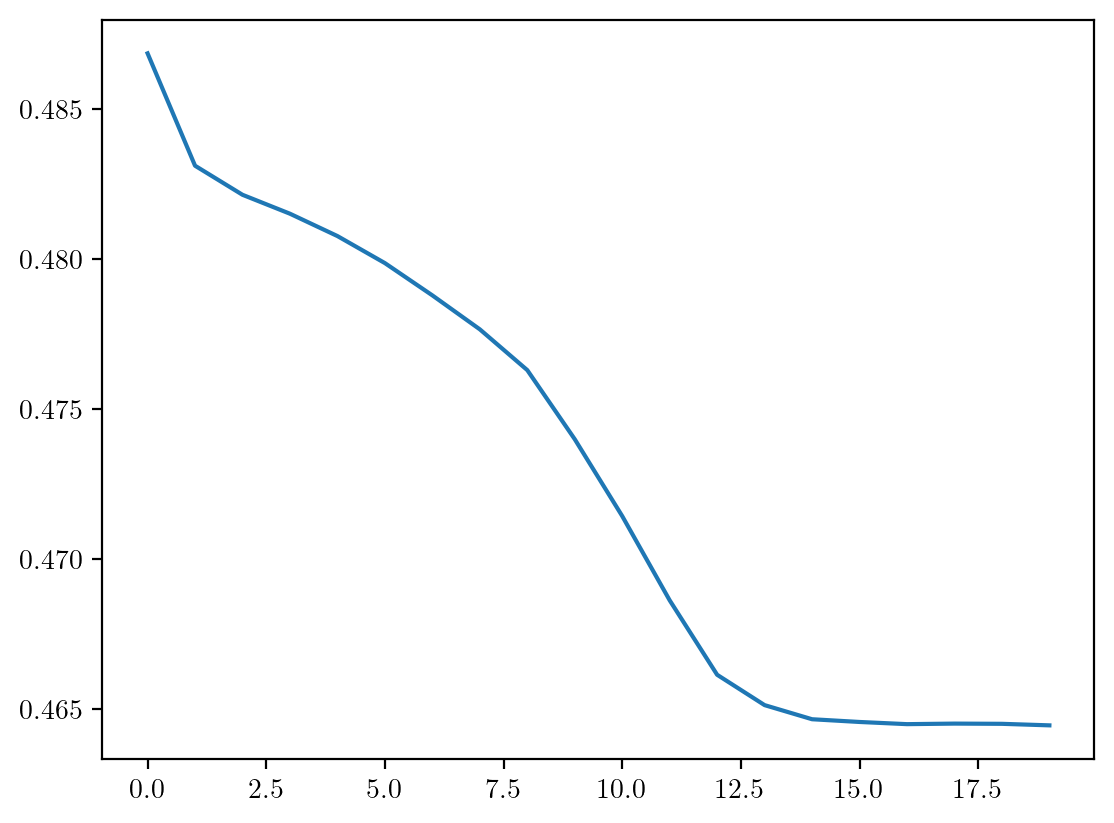

Ranks: r1 2, r2 2, r3 2
Iteration: 0
tensor(0.4644, device='cuda:0', dtype=torch.float64)
tensor(-1.2185, device='cuda:0', dtype=torch.float64)
tensor(11.5051, device='cuda:0', dtype=torch.float64)
tensor(15.5802, device='cuda:0', dtype=torch.float64)
tensor(17.2051, device='cuda:0', dtype=torch.float64)
tensor(27.4800, device='cuda:0', dtype=torch.float64)
tensor(20.2129, device='cuda:0', dtype=torch.float64)
tensor(31.8852, device='cuda:0', dtype=torch.float64)
tensor(22.0049, device='cuda:0', dtype=torch.float64)
tensor(33.4021, device='cuda:0', dtype=torch.float64)
tensor(22.3975, device='cuda:0', dtype=torch.float64)
tensor(35.1477, device='cuda:0', dtype=torch.float64)
tensor(23.0261, device='cuda:0', dtype=torch.float64)
tensor(35.3845, device='cuda:0', dtype=torch.float64)
tensor(23.6933, device='cuda:0', dtype=torch.float64)
tensor(35.3769, device='cuda:0', dtype=torch.float64)
tensor(24.5040, device='cuda:0', dtype=torch.float64)
tensor(34.8895, device='cuda:0', dtype=torch.f

In [30]:
import importlib

importlib.reload(DeSTOT_LRDist)

gamma=100
tau_out=0.01
tau_in=10
alpha = 0.0
beta = 0.0


# First pair
init_args = (None, None, None)
Q1,R1,T1, errs = DeSTOT_LRDist.DeSTOT_LR_opt((C12, torch.eye(C12.shape[1]).type(torch.DoubleTensor).to(device)),
                                             (A11, torch.eye(A11.shape[1]).type(torch.DoubleTensor).to(device)), 
                                             (A22, torch.eye(A22.shape[1]).type(torch.DoubleTensor).to(device)), \
                                          a=None, b=None, \
                                          r=2, r2=2, max_iter= 30, device=device, \
                                         returnFull=False, alpha=alpha, beta=beta, \
                                        min_iter = 20, initialization='Full', tau_out=tau_out, tau_in=tau_in, gamma=gamma, \
                                        dtype=torch.float64, updateR = True, updateQ = True, updateT = True, init_args=init_args)

gQ = Q1.T @ torch.ones(Q1.shape[0]).type(torch.DoubleTensor).to(device)
gR = R1.T @ torch.ones(R1.shape[0]).type(torch.DoubleTensor).to(device)

print(gQ)
print(gR)

z1 = torch.diag(1/ gQ) @ Q1.T @ X1
z2 = torch.diag(1/ gR) @ R1.T @ X2

# Second pair
init_args = (None, None, None)
Q2,R2,T2, errs = DeSTOT_LRDist.DeSTOT_LR_opt((C23, torch.eye(C23.shape[1]).type(torch.DoubleTensor).to(device)),
                                             (A22, torch.eye(A22.shape[1]).type(torch.DoubleTensor).to(device)), 
                                             (A33, torch.eye(A33.shape[1]).type(torch.DoubleTensor).to(device)), \
                                          a=None, b=None, \
                                          r=2, r2=2, max_iter=30, device=device, \
                                         returnFull=False, alpha=alpha, beta=beta, \
                                        min_iter = 20, initialization='Full', tau_out=tau_out, tau_in=tau_in, gamma=gamma, \
                                        dtype=torch.float64, updateR = True, updateQ = True, updateT = True, init_args=init_args)

gQ = Q2.T @ torch.ones(Q2.shape[0]).type(torch.DoubleTensor).to(device)
gR = R2.T @ torch.ones(R2.shape[0]).type(torch.DoubleTensor).to(device)

z2_prime = torch.diag(1/ gQ) @ Q2.T @ X2
z3 = torch.diag(1/ gR) @ R2.T @ X3


# Initialize as arguments
init_args = (Q1, R2)

tau_out=1000#100
tau_in=10

# Learn smoothed co-clustering Q_t
Q_t, T_tm1t, T_ttp1 = DeSTOT_LRDist.DeSTOT_LR_opt_multimarginal((C12, torch.eye(C12.shape[1]).type(torch.DoubleTensor).to(device)), \
                                                               (A11, torch.eye(A11.shape[1]).type(torch.DoubleTensor).to(device)), 
                                                                 (A22, torch.eye(A22.shape[1]).type(torch.DoubleTensor).to(device)), \
                                                (C23, torch.eye(C23.shape[1]).type(torch.DoubleTensor).to(device)), \
                                             (A22, torch.eye(A22.shape[1]).type(torch.DoubleTensor).to(device)), \
                                             (A33, torch.eye(A33.shape[1]).type(torch.DoubleTensor).to(device)), r=2, max_iter=100, device=device, \
                                             returnFull=False, alpha=alpha, beta=beta, \
                                            min_iter = 100, initialization='Full', tau_out=tau_out, tau_in=tau_in, gamma=gamma, \
                                            dtype=torch.float64, init_args=init_args)
gQ = Q_t.T @ torch.ones(Q_t.shape[0]).type(torch.DoubleTensor).to(device)
z2_smoothed = torch.diag(1/ gQ) @ Q_t.T @ X2

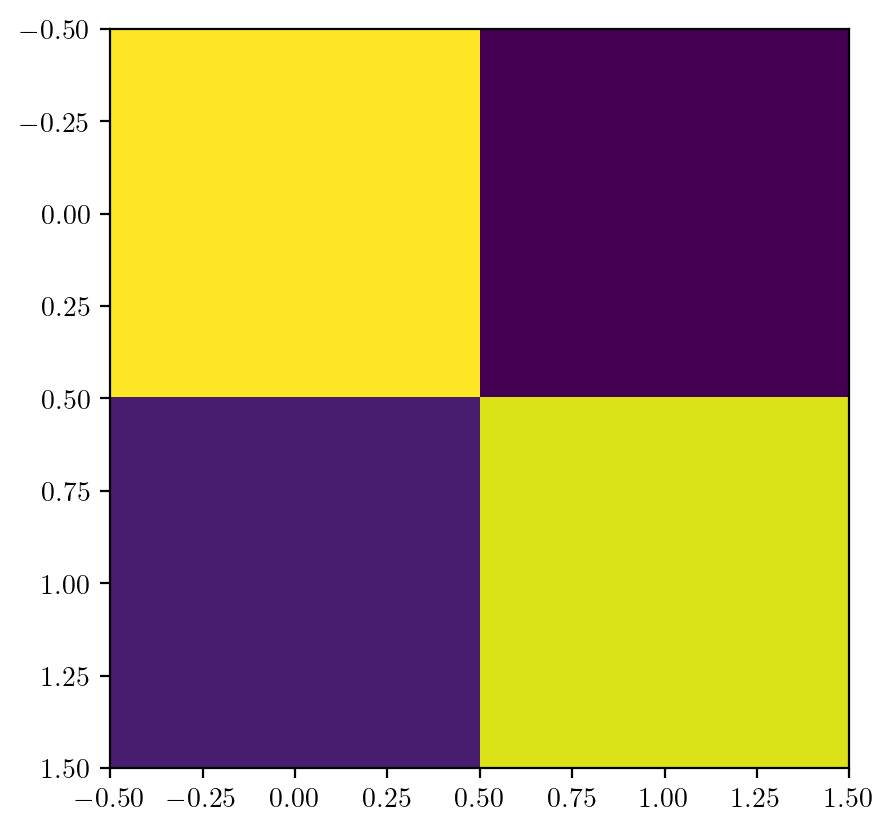

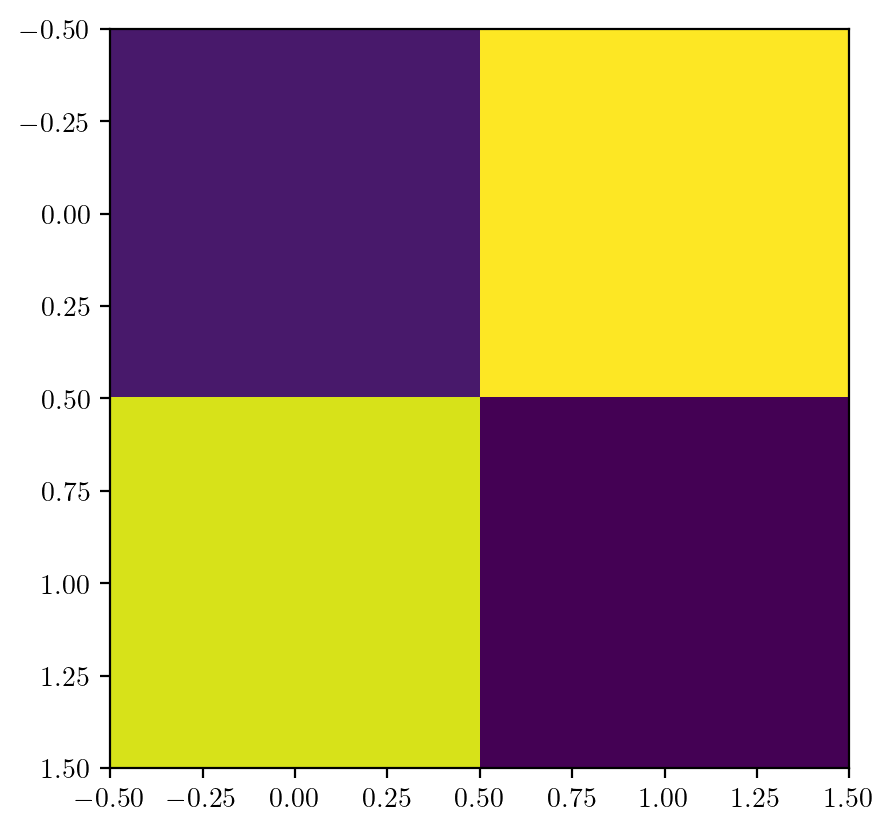

In [31]:
import clustering

#C0, C1 = clustering.ancestral_clustering(Q1.cpu().numpy(),Q_t.cpu().numpy(),T_tm1t.cpu().numpy(), full_P = True)
#C1, C2 = clustering.ancestral_clustering(Q_t.cpu().numpy(),R2.cpu().numpy(),T_ttp1.cpu().numpy(), full_P = True)

plt.imshow(T_tm1t.cpu().numpy())
plt.show()
plt.imshow(T_ttp1.cpu().numpy())
plt.show()

C0 = R1

C1 = Q_t #(T_tm1t @ torch.diag(1/ (Q_t.T @ torch.ones(Q_t.shape[0]).type(torch.DoubleTensor).to(device)) ) @ Q_t.T).T

C2 = Q2 #(T_ttp1 @ torch.diag(1/ (R2.T @ torch.ones(R2.shape[0]).type(torch.DoubleTensor).to(device)) ) @ R2.T).T

In [32]:
'''
import clustering

plt.imshow(T_tm1t.cpu().numpy())
plt.show()
plt.imshow(T_ttp1.cpu().numpy())
plt.show()

C0 = Q1
C1 = (T_tm1t @ torch.diag(1/ (Q_t.T @ torch.ones(Q_t.shape[0]).type(torch.DoubleTensor).to(device)) ) @ Q_t.T).T
C2 = (T_ttp1 @ torch.diag(1/ (R2.T @ torch.ones(R2.shape[0]).type(torch.DoubleTensor).to(device)) ) @ R2.T).T

print(torch.argmax(C0, axis=1))
print(torch.argmax(C1, axis=1))
print(torch.argmax(C2, axis=1))
'''

'\nimport clustering\n\nplt.imshow(T_tm1t.cpu().numpy())\nplt.show()\nplt.imshow(T_ttp1.cpu().numpy())\nplt.show()\n\nC0 = Q1\nC1 = (T_tm1t @ torch.diag(1/ (Q_t.T @ torch.ones(Q_t.shape[0]).type(torch.DoubleTensor).to(device)) ) @ Q_t.T).T\nC2 = (T_ttp1 @ torch.diag(1/ (R2.T @ torch.ones(R2.shape[0]).type(torch.DoubleTensor).to(device)) ) @ R2.T).T\n\nprint(torch.argmax(C0, axis=1))\nprint(torch.argmax(C1, axis=1))\nprint(torch.argmax(C2, axis=1))\n'

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


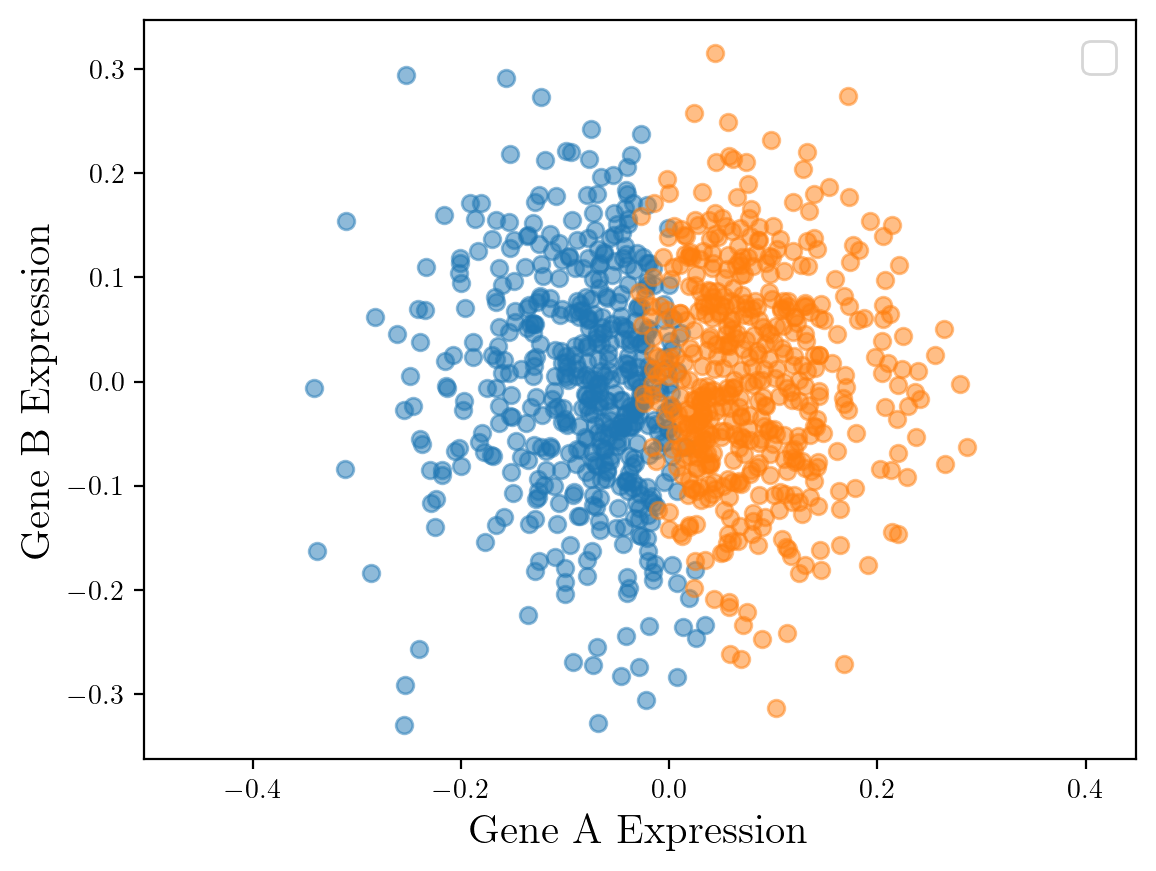

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


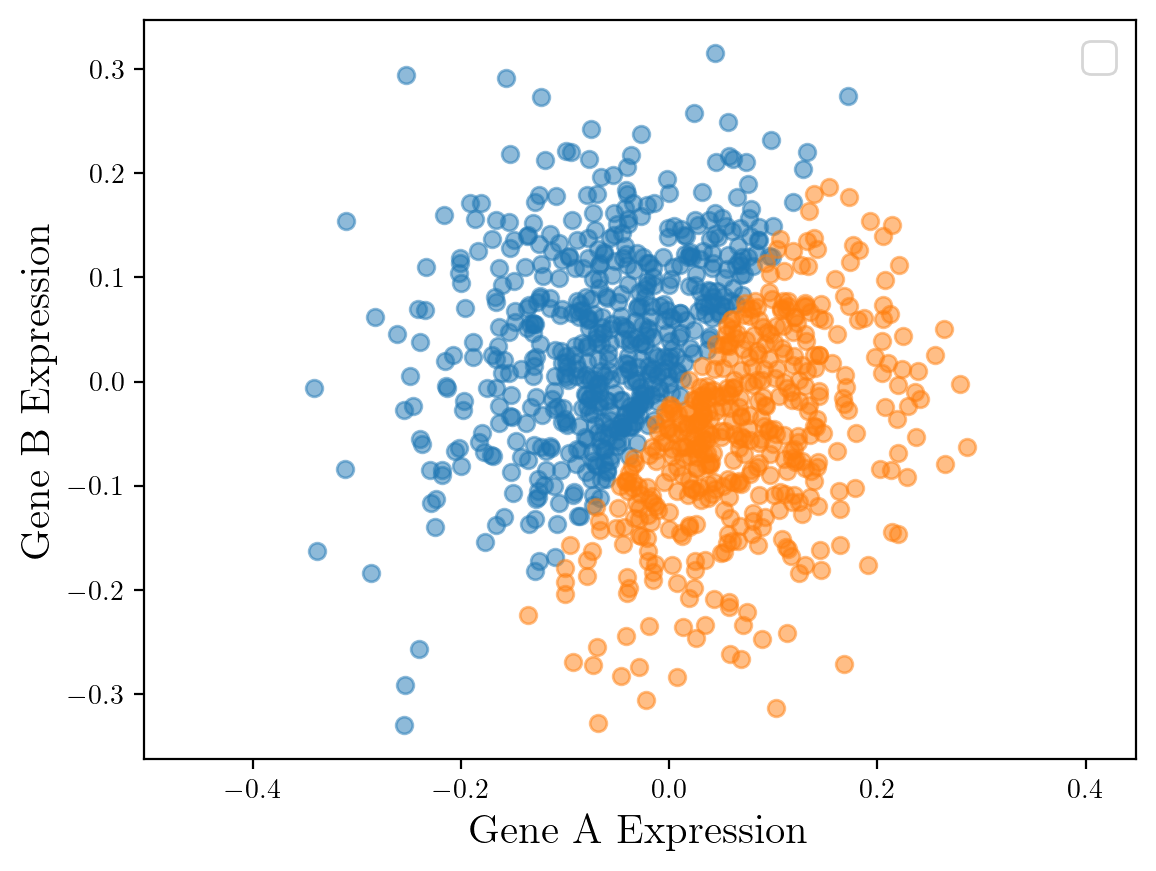

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


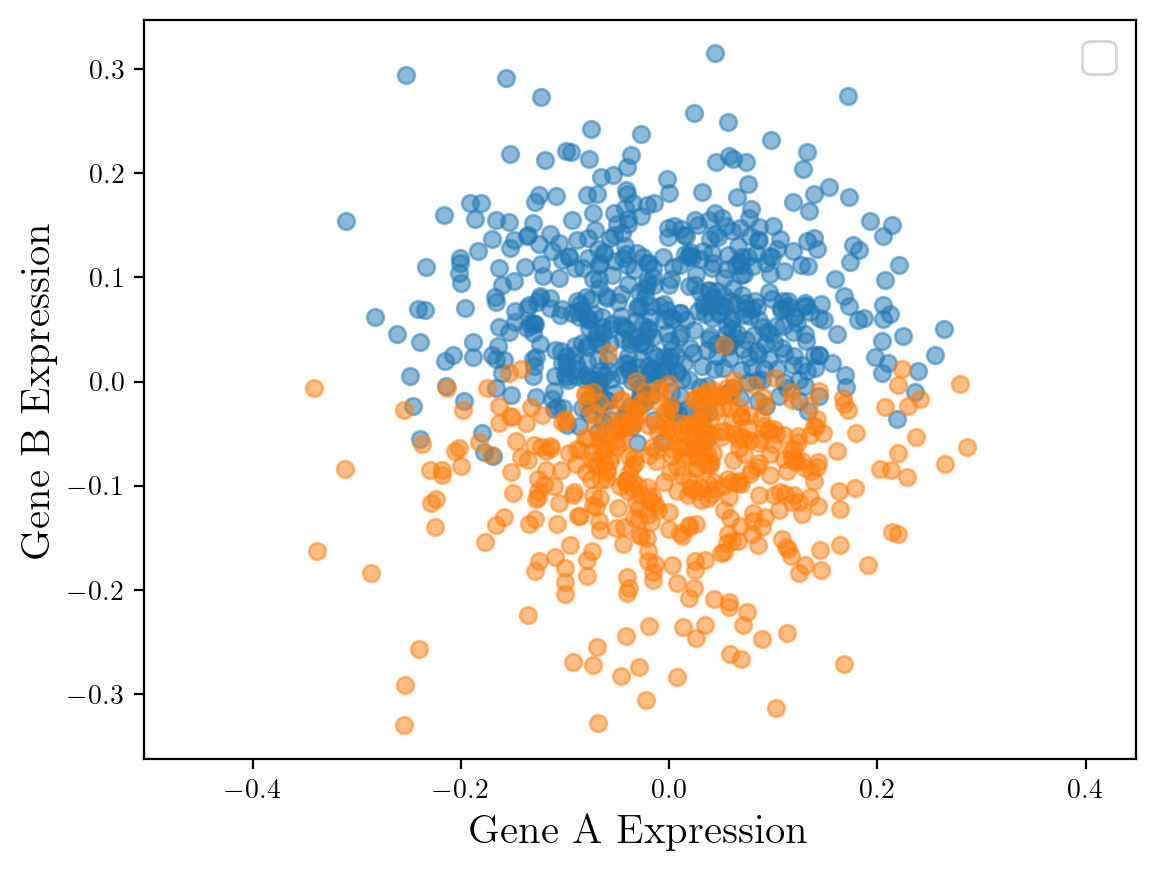

In [33]:
### Plotting ###
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Times New Roman"],
    "figure.dpi": 200  # Set the DPI
})

size = 15

for c in range(rank):
    XC = X2[torch.argmax(C0, axis=1) == c].cpu().numpy()
    plt.scatter(XC[:,0], XC[:, 1], alpha=0.5)

plt.xlabel(r'Gene A Expression', size=size)
plt.ylabel(r'Gene B Expression', size=size)
plt.legend(fontsize=size)
plt.axis('equal')
plt.show()

for c in range(rank):
    XC = X2[torch.argmax(C1, axis=1) == c].cpu().numpy()
    plt.scatter(XC[:,0], XC[:, 1], alpha=0.5)

plt.xlabel(r'Gene A Expression', size=size)
plt.ylabel(r'Gene B Expression', size=size)
plt.legend(fontsize=size)
plt.axis('equal')
plt.show()

for c in range(rank):
    XC = X2[torch.argmax(C2, axis=1) == c].cpu().numpy()
    plt.scatter(XC[:,0], XC[:, 1], alpha=0.5)

plt.xlabel(r'Gene A Expression', size=size)
plt.ylabel(r'Gene B Expression', size=size)
plt.legend(fontsize=size)
plt.axis('equal')
plt.show()

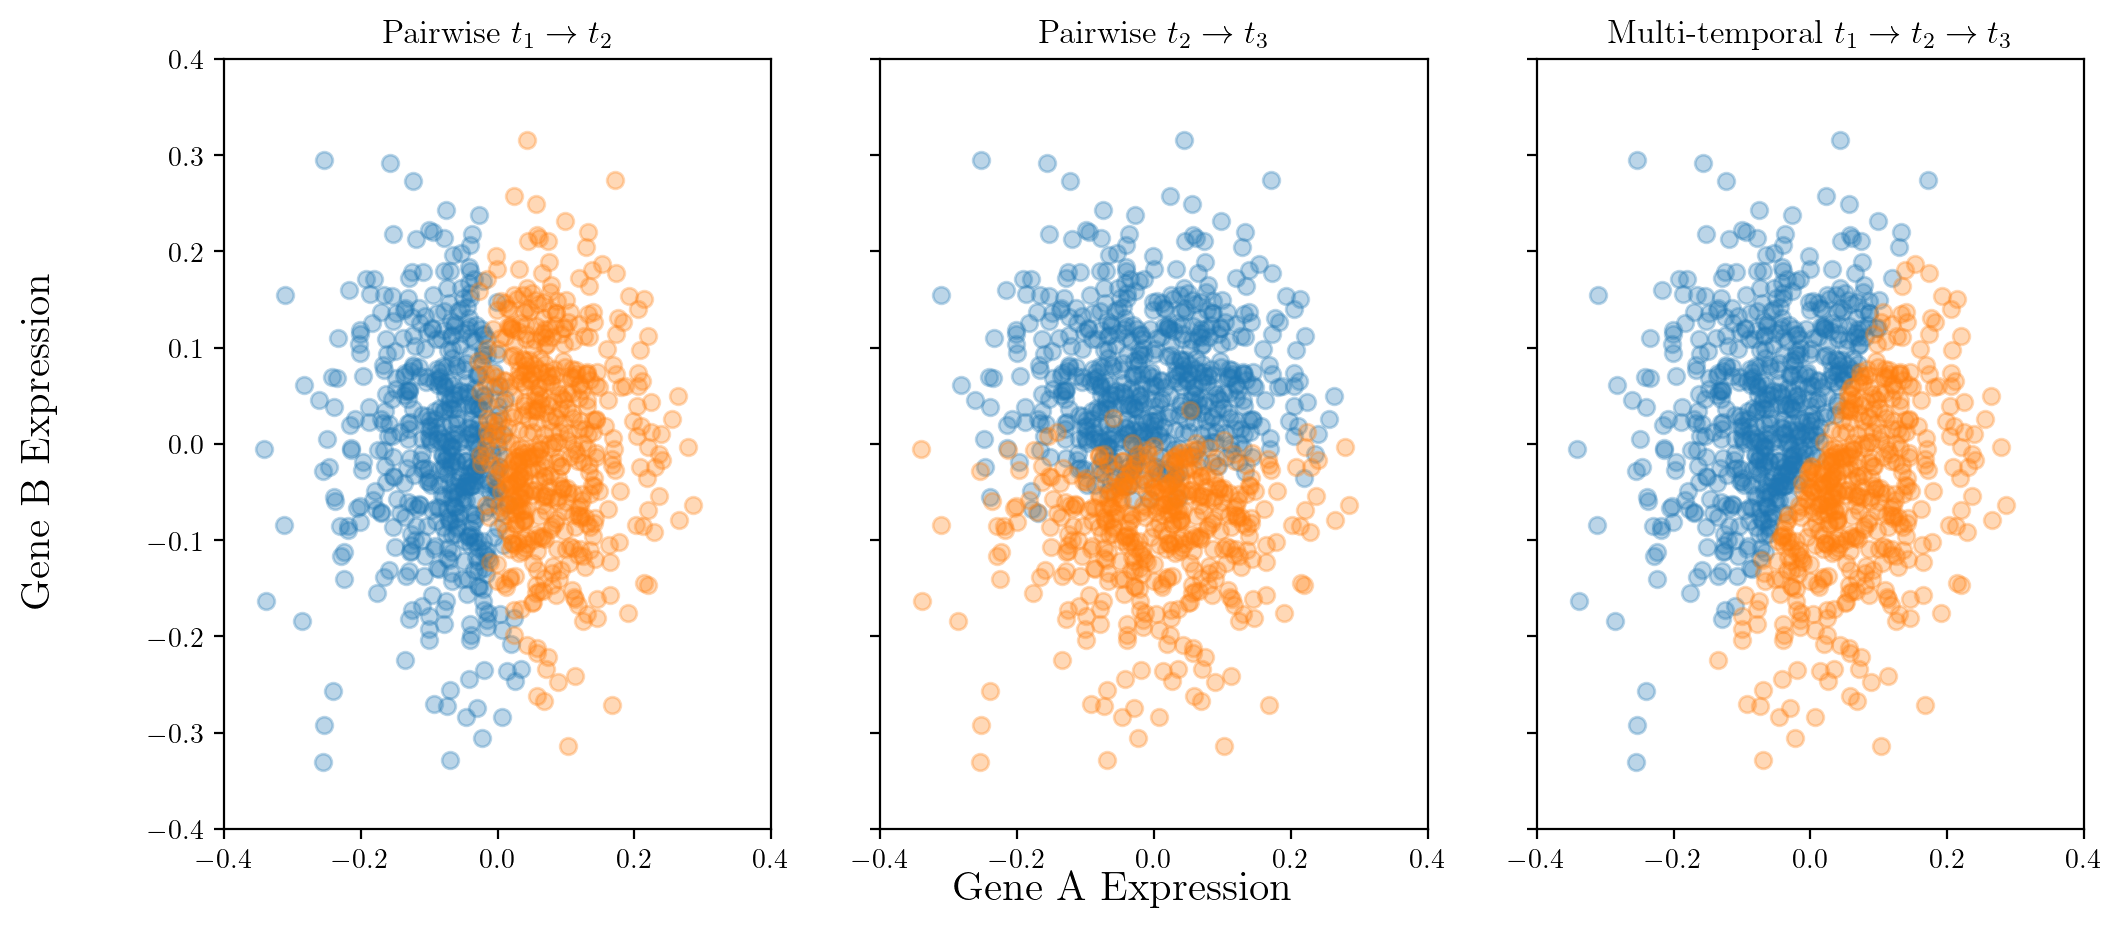

In [36]:
# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(12, 5), sharex=True, sharey=True)

axs[0].set_title(r'Pairwise $t_{1} \to t_{2}$')
for c in range(rank):
    XC = X2[torch.argmax(C0, axis=1) == c].cpu().numpy()
    axs[0].scatter(XC[:,0], XC[:, 1], alpha=0.3)


axs[1].set_title(r'Pairwise $t_{2} \to t_{3}$')
for c in range(rank):
    XC = X2[torch.argmax(C2, axis=1) == c].cpu().numpy()
    axs[1].scatter(XC[:,0], XC[:, 1], alpha=0.3)

axs[2].set_title(r'Multi-temporal $t_{1} \to t_{2} \to t_{3}$')
for c in range(rank):
    XC = X2[torch.argmax(C1, axis=1) == c].cpu().numpy()
    axs[2].scatter(XC[:,0], XC[:, 1], alpha=0.3)


# Shared labels
fig.text(0.5, 0.04, r'Gene A Expression', ha='center', size=size)
fig.text(0.04, 0.5, r'Gene B Expression', va='center', rotation='vertical', size=size)

# Set the same x and y limits
axs[0].set_xlim(-0.4, 0.4)
axs[0].set_ylim(-0.4, 0.4)
axs[1].set_xlim(-0.4, 0.4)
axs[1].set_ylim(-0.4, 0.4)

plt.savefig('synthetic2.svg')
plt.show()